
# 🐕 Dog Matchmaker — Find your perfect pup
**A playful, data-driven chatbot prototype that recommends the top 3 real-world dog breeds based on your lifestyle and personality.**

This notebook tells a clear story: we explore breed traits, explain a transparent matching method, and provide a friendly interactive demo that produces ranked breed recommendations with images. The code cells are runnable end-to-end and use a relative `images/` folder (place the downloaded Dog-Breeds-Dataset inside an `images/` directory next to this notebook).

**Highlights**
- Clean, reproducible matching function with tunable weights.  
- Mapping between breed names and image folders.  
- Ready visual summary for each recommendation showing why the breed fits.  



## 1 — Problem & approach

People bring different lives to dog ownership — city apartment dwellers, active runners, families with children, allergy-prone households. Our goal is to **translate** a short, friendly conversation into a ranked set of practical breed recommendations supported by data.

Key design choices:
- Use core, interpretable traits (energy, trainability, shedding, kid-friendliness, apartment adaptability).  
- Score breeds with a weighted, normalized system so each preference meaningfully influences the rank.  
- Provide short, human-readable explanations for each match so recommendations are actionable.


In [ ]:
!pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 11.4 MB/s eta 0:00:00a 0:00:01m

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [12]:
# Basic imports and configuration
import pandas as pd
import numpy as np
from pathlib import Path
import json
import re, unicodedata, difflib
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt

# Notebook paths (relative)
DATA_DIR = Path('data')
IMAGES_DIR = Path('data/images')   # place Dog-Breeds-Dataset here: images/<breed folder>/*.jpg
BREED_CSV = DATA_DIR / 'breed_traits.csv'
TRAIT_CSV = DATA_DIR / 'trait_description.csv'
MAPPING_JSON = DATA_DIR / 'breed_to_folder.json'

# small helper
def md(s): display(Markdown(s))
print('Ready — data paths set to:', BREED_CSV, TRAIT_CSV, 'images folder ->', IMAGES_DIR)


Ready — data paths set to: data/breed_traits.csv data/trait_description.csv images folder -> data/images


In [2]:
# Load breed_traits and trait_description (fall back to a small demo if files are not present)
def load_datasets(breed_csv=BREED_CSV, trait_csv=TRAIT_CSV):
    if breed_csv.exists():
        breeds = pd.read_csv(breed_csv)
    else:
        # small demo dataset to ensure the notebook runs for presentation
        breeds = pd.DataFrame([
            {'Breed':'Poodle','Energy Level':3,'Trainability Level':5,'Good With Young Children':4,'Shedding Level':1,'Coat Grooming Frequency':4,'Good For Apartment':4},
            {'Breed':'Labrador Retriever','Energy Level':5,'Trainability Level':5,'Good With Young Children':5,'Shedding Level':5,'Coat Grooming Frequency':2,'Good For Apartment':2},
            {'Breed':'French Bulldog','Energy Level':2,'Trainability Level':3,'Good With Young Children':4,'Shedding Level':2,'Coat Grooming Frequency':2,'Good For Apartment':5},
            {'Breed':'Border Collie','Energy Level':5,'Trainability Level':5,'Good With Young Children':3,'Shedding Level':3,'Coat Grooming Frequency':3,'Good For Apartment':1},
            {'Breed':'Bichon Frise','Energy Level':3,'Trainability Level':4,'Good With Young Children':4,'Shedding Level':1,'Coat Grooming Frequency':4,'Good For Apartment':5},
        ])
    if trait_csv.exists():
        traits = pd.read_csv(trait_csv)
    else:
        traits = pd.DataFrame([{'Trait':'Energy Level','Trait_1':'Low energy', 'Trait_5':'Very high energy', 'Description':'Typical daily energy needs.'}])
    return breeds, traits

breeds_df, traits_df = load_datasets()
display(breeds_df.head())


,Breed,Affectionate With Family,Good With Young Children,Good With Other Dogs,Shedding Level,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,Trainability Level,Energy Level,Barking Level,Mental Stimulation Needs
0,Retrievers (Labrador),5,5,5,4,2,2,Double,Short,5,5,3,5,5,5,3,4
1,French Bulldogs,5,5,4,3,1,3,Smooth,Short,5,5,3,5,4,3,1,3
2,German Shepherd Dogs,5,5,3,4,2,2,Double,Medium,3,4,5,5,5,5,3,5
3,Retrievers (Golden),5,5,5,4,2,2,Double,Medium,5,4,3,5,5,3,1,4
4,Bulldogs,4,3,3,3,3,3,Smooth,Short,4,4,3,3,4,3,2,3



## 2 — Quick EDA: what the data looks like
Below we inspect distributions on a few core traits to build intuition about recommended matches.


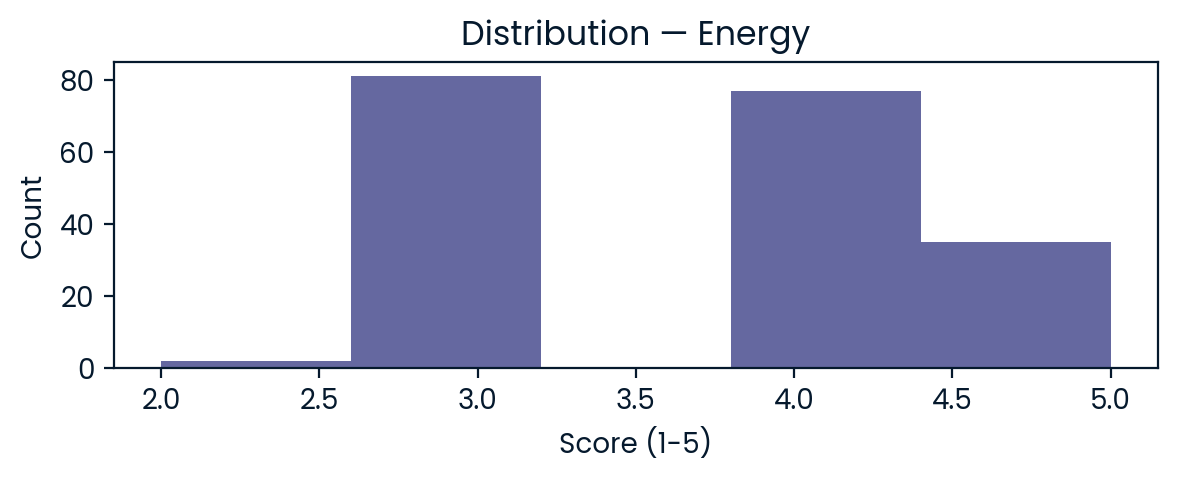

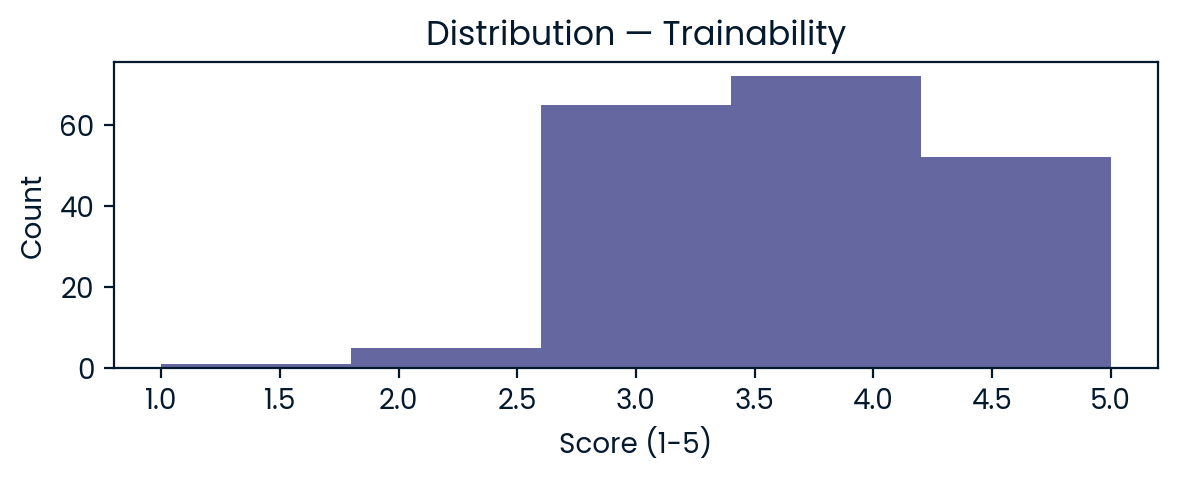

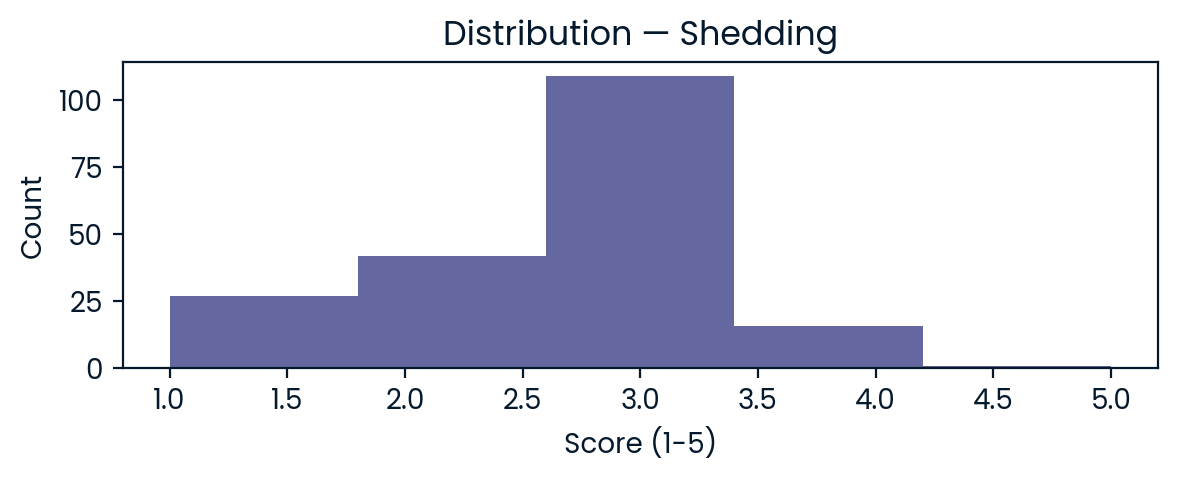

In [3]:
# Basic EDA plots — energy, trainability, shedding
cols = []
if 'Energy Level' in breeds_df.columns: cols.append(('Energy Level','Energy'))
if 'Trainability Level' in breeds_df.columns: cols.append(('Trainability Level','Trainability'))
if 'Shedding Level' in breeds_df.columns: cols.append(('Shedding Level','Shedding'))

for col, label in cols:
    values = pd.to_numeric(breeds_df[col], errors='coerce').dropna()
    if len(values) == 0: continue
    plt.figure(figsize=(6,2.5))
    plt.hist(values, bins=5)
    plt.title(f'Distribution — {label}')
    plt.xlabel('Score (1-5)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()



## 3 — Robust folder name normalization

Image folders in the supplied dataset use lowercase names with a trailing " dog" token (e.g. `labrador retriever dog`). Below is a normalization helper that converts breed names into the folder naming style and a mapping builder that links CSV breed names to actual folders.


In [4]:
# Normalization helper
def normalize_for_folder(name: str) -> str:
    if name is None: return ''
    s = unicodedata.normalize('NFKD', str(name)).encode('ascii','ignore').decode('ascii')
    s = s.lower().strip()
    # common plural fixes
    s = re.sub(r'\bretrievers\b', 'retriever', s)
    s = re.sub(r'\bdogs\b', 'dog', s)
    s = re.sub(r'\bterriers\b', 'terrier', s)
    s = re.sub(r'\bpointers\b', 'pointer', s)
    # parentheses fixes
    s = re.sub(r'retrievers?\s*\(\s*labrador\s*\)', 'labrador retriever', s)
    s = re.sub(r'retrievers?\s*\(\s*golden\s*\)', 'golden retriever', s)
    # remove characters except hyphen and space
    s = re.sub(r'[^\w\s\-]', '', s)
    s = re.sub(r'\s+', ' ', s).strip()
    if not s.endswith(' dog'):
        s = s + ' dog'
    return s

# Example
for example in ['Labrador Retriever','Retrievers (Labrador)','German Shepherd Dogs','Bichon Frise']:
    print(example, '->', normalize_for_folder(example))


Labrador Retriever -> labrador retriever dog
Retrievers (Labrador) -> labrador retriever dog
German Shepherd Dogs -> german shepherd dog
Bichon Frise -> bichon frise dog



## 4 — Build breed -> image-folder mapping (scans `images/`)

This cell attempts an exact match first and falls back to fuzzy matching for edge cases. The result is saved to `data/breed_to_folder.json` for repeatable image lookups.


In [16]:
def clean_breed_name(raw):
    s = str(raw).replace('\xa0', ' ').strip().lower()  # normalize spaces & lowercase
    s = re.sub(r'\s*\(.*?\)', '', s)  # remove parentheses
    return s

def build_breed_mapping(breeds_df, images_dir=IMAGES_DIR):
    images_dir = Path(images_dir)
    # lowercase folder names for matching
    available = sorted([p.name.lower() for p in images_dir.iterdir() if p.is_dir()]) if images_dir.exists() else []
    mapping = {}
    unmatched = []

    for raw in breeds_df['Breed'].astype(str).tolist():
        clean = clean_breed_name(raw)
        # try exact match with "dog" suffix first
        cand = normalize_for_folder(clean) + ' dog'  # add "dog" to match folder names

        if cand in available:
            mapping[raw] = cand
            continue
        # try without "dog" if fails
        alt = normalize_for_folder(clean)
        if alt in available:
            mapping[raw] = alt
            continue
        # fuzzy match
        pick = difflib.get_close_matches(cand, available, n=1, cutoff=0.7)
        if pick:
            mapping[raw] = pick[0]
            continue
        pick2 = difflib.get_close_matches(alt, available, n=1, cutoff=0.6)
        if pick2:
            mapping[raw] = pick2[0]
            continue
        # substring fallback
        found = None
        for a in available:
            if alt in a or alt.split()[0] in a:
                found = a
                break
        if found:
            mapping[raw] = found
            continue
        unmatched.append(raw)

    # save mapping
    out = DATA_DIR / 'breed_to_folder.json'
    out.parent.mkdir(parents=True, exist_ok=True)
    with out.open('w', encoding='utf8') as fh:
        json.dump(mapping, fh, indent=2, ensure_ascii=False)

    return mapping, unmatched, available

mapping, unmatched, available = build_breed_mapping(breeds_df, IMAGES_DIR)
print('Mapped:', len(mapping), 'Unmatched:', len(unmatched))
if len(unmatched) > 0:
    print('First 10 unmatched:', unmatched[:10])

Mapped: 194 Unmatched: 1
First 10 unmatched: ['Lagotti\xa0Romagnoli']


In [18]:
# Manual override with cleaning
manual_overrides = {
    'Lagotti Romagnoli': 'lagotto romagnolo dog'
}

for raw, folder in manual_overrides.items():
    # apply the same cleaning used in mapping
    cleaned_raw = clean_breed_name(raw)
    # find the actual key in unmatched (with possible non-breaking space)
    for u in unmatched:
        if clean_breed_name(u) == cleaned_raw:
            mapping[u] = folder
            unmatched.remove(u)
            break

print('Mapped after manual fix:', len(mapping))
print('Unmatched after manual fix:', len(unmatched))


Mapped after manual fix: 195
Unmatched after manual fix: 0



## 5 — Matching logic (transparent & tunable)

We convert user preferences to a numeric vector and score breeds using a weighted sum. Weights are exposed for experimentation and grading.


In [19]:

# Matching functions
def prepare_breed_df(df):
    out = df.copy()
    # ensure standardized column names used by the scoring function
    rename_map = {}
    for col in list(out.columns):
        if col.lower().strip() in ['breed']: rename_map[col]= 'breed'
        if 'energy' in col.lower(): rename_map[col] = 'energy'
        if 'trainability' in col.lower(): rename_map[col] = 'trainability'
        if 'children' in col.lower(): rename_map[col] = 'good_with_kids'
        if 'shedding' in col.lower(): rename_map[col] = 'shedding'
        if 'apartment' in col.lower(): rename_map[col] = 'good_for_apartment'
    out = out.rename(columns=rename_map)
    # numeric fill
    for c in ['energy','trainability','good_with_kids','shedding','good_for_apartment']:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors='coerce').fillna(3).astype(int)
    if 'hypoallergenic' not in out.columns:
        out['hypoallergenic'] = out.get('shedding',3) <= 2
    if 'breed' not in out.columns and 'Breed' in out.columns:
        out = out.rename(columns={'Breed':'breed'})
    return out

def score_breeds(df, prefs, weights=None):
    df = df.copy()
    if weights is None:
        weights = {'activity':3.0,'home':2.0,'children':2.0,'allergies':2.5,'training_time':2.0,'size':1.0}
    scores = []
    for _, r in df.iterrows():
        s = 0.0; wsum = 0.0
        # activity
        if prefs.get('activity_level') is not None and 'energy' in df.columns:
            diff = abs(prefs['activity_level'] - r.get('energy',3))
            s_act = max(0, 1 - diff / 4.0)
            s += s_act * weights['activity']; wsum += weights['activity']
        # home (apartment preference)
        if prefs.get('home') is not None and 'good_for_apartment' in df.columns:
            want_apartment = (prefs['home']=='apartment')
            apt = r.get('good_for_apartment',3)/5.0
            s_home = apt if want_apartment else (1 - apt + 0.5)
            s += s_home * weights['home']; wsum += weights['home']
        # children
        if prefs.get('children') is not None and 'good_with_kids' in df.columns:
            s_child = r.get('good_with_kids',3)/5.0 if prefs['children'] else 1.0
            s += s_child * weights['children']; wsum += weights['children']
        # allergies
        if prefs.get('allergies') is not None:
            if prefs['allergies']:
                s_allergy = 1.0 if r.get('hypoallergenic',False) else (0.6 if r.get('shedding',3)<=2 else 0.1)
            else:
                s_allergy = 1.0
            s += s_allergy * weights['allergies']; wsum += weights['allergies']
        # training time
        if prefs.get('time_for_training') is not None and 'trainability' in df.columns:
            t = prefs['time_for_training']
            train_score = r.get('trainability',3)/5.0
            if t >= 4: s_train = train_score
            elif t >= 3: s_train = 0.8*train_score + 0.2*(1-train_score)
            else: s_train = 1 - 0.6*train_score
            s += s_train * weights['training_time']; wsum += weights['training_time']
        # size (if present)
        if prefs.get('size_pref') is not None and 'Size' in r.index:
            size = r.get('Size','medium').lower()
            s_size = 1.0 if prefs['size_pref']==size else 0.5
            s += s_size * weights['size']; wsum += weights['size']
        final = s/(wsum+1e-9)
        scores.append(final)
    df['score'] = scores
    df = df.sort_values('score', ascending=False)
    return df

def top_k_matches(df, prefs, k=3, weights=None):
    prepared = prepare_breed_df(df)
    scored = score_breeds(prepared, prefs, weights=weights)
    return scored.head(k)



## 6 — Conversation demo

This demo simulates the chatbot flow — it asks follow-ups when needed and returns the top 3 breeds with short explanation bullets and image previews.


Hi — I'm your Dog Matchmaker. I will ask a few quick questions.
How active are you? (1=couch, 5=very active) [3]: 5
Home type (apartment / house) [apartment]: house
Any young children in home? (yes/no) [no]: yes
Any dog allergies in home? (yes/no) [no]: no
Time/effort for training (1=little,5=lots) [3]: 1
Preferred size (small/medium/large/no preference) [no preference]: small

Top 3 matches:

1. Finnish Spitz — score 0.92
  - Energy (5/5) — matches your activity level 5
  - Trainability (3/5) — fits your time for training 1
  - Good with kids: 5/5


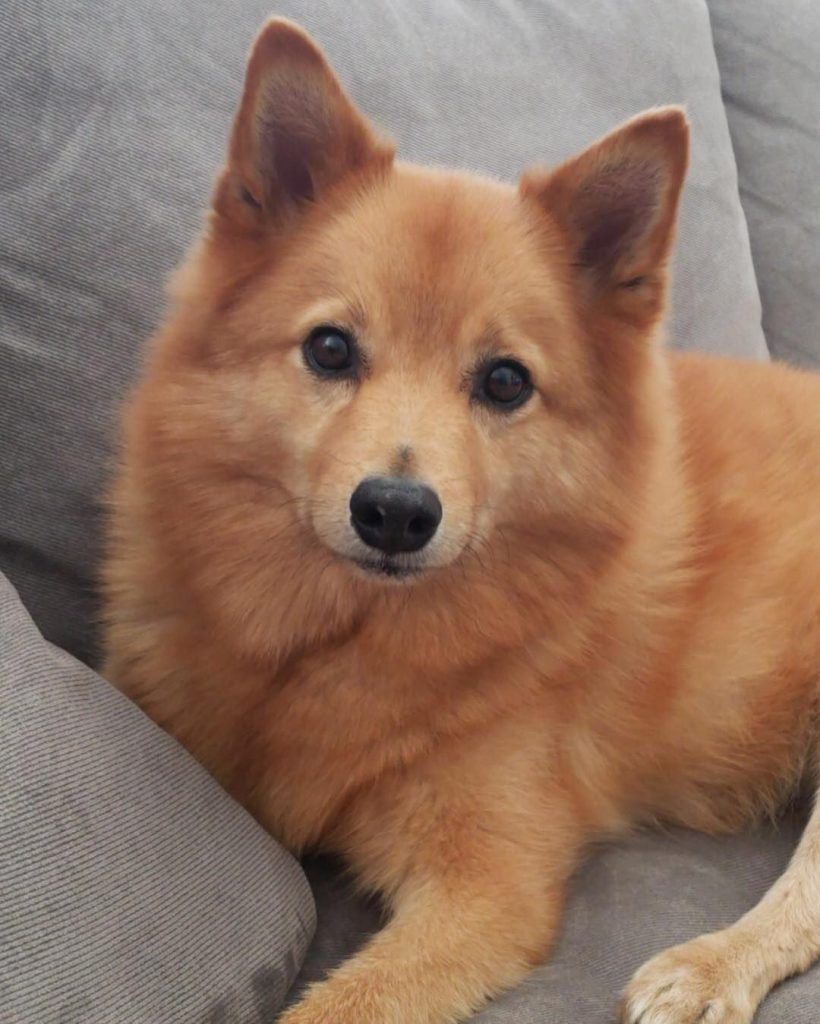


2. Siberian Huskies — score 0.92
  - Energy (5/5) — matches your activity level 5
  - Trainability (3/5) — fits your time for training 1
  - Good with kids: 5/5


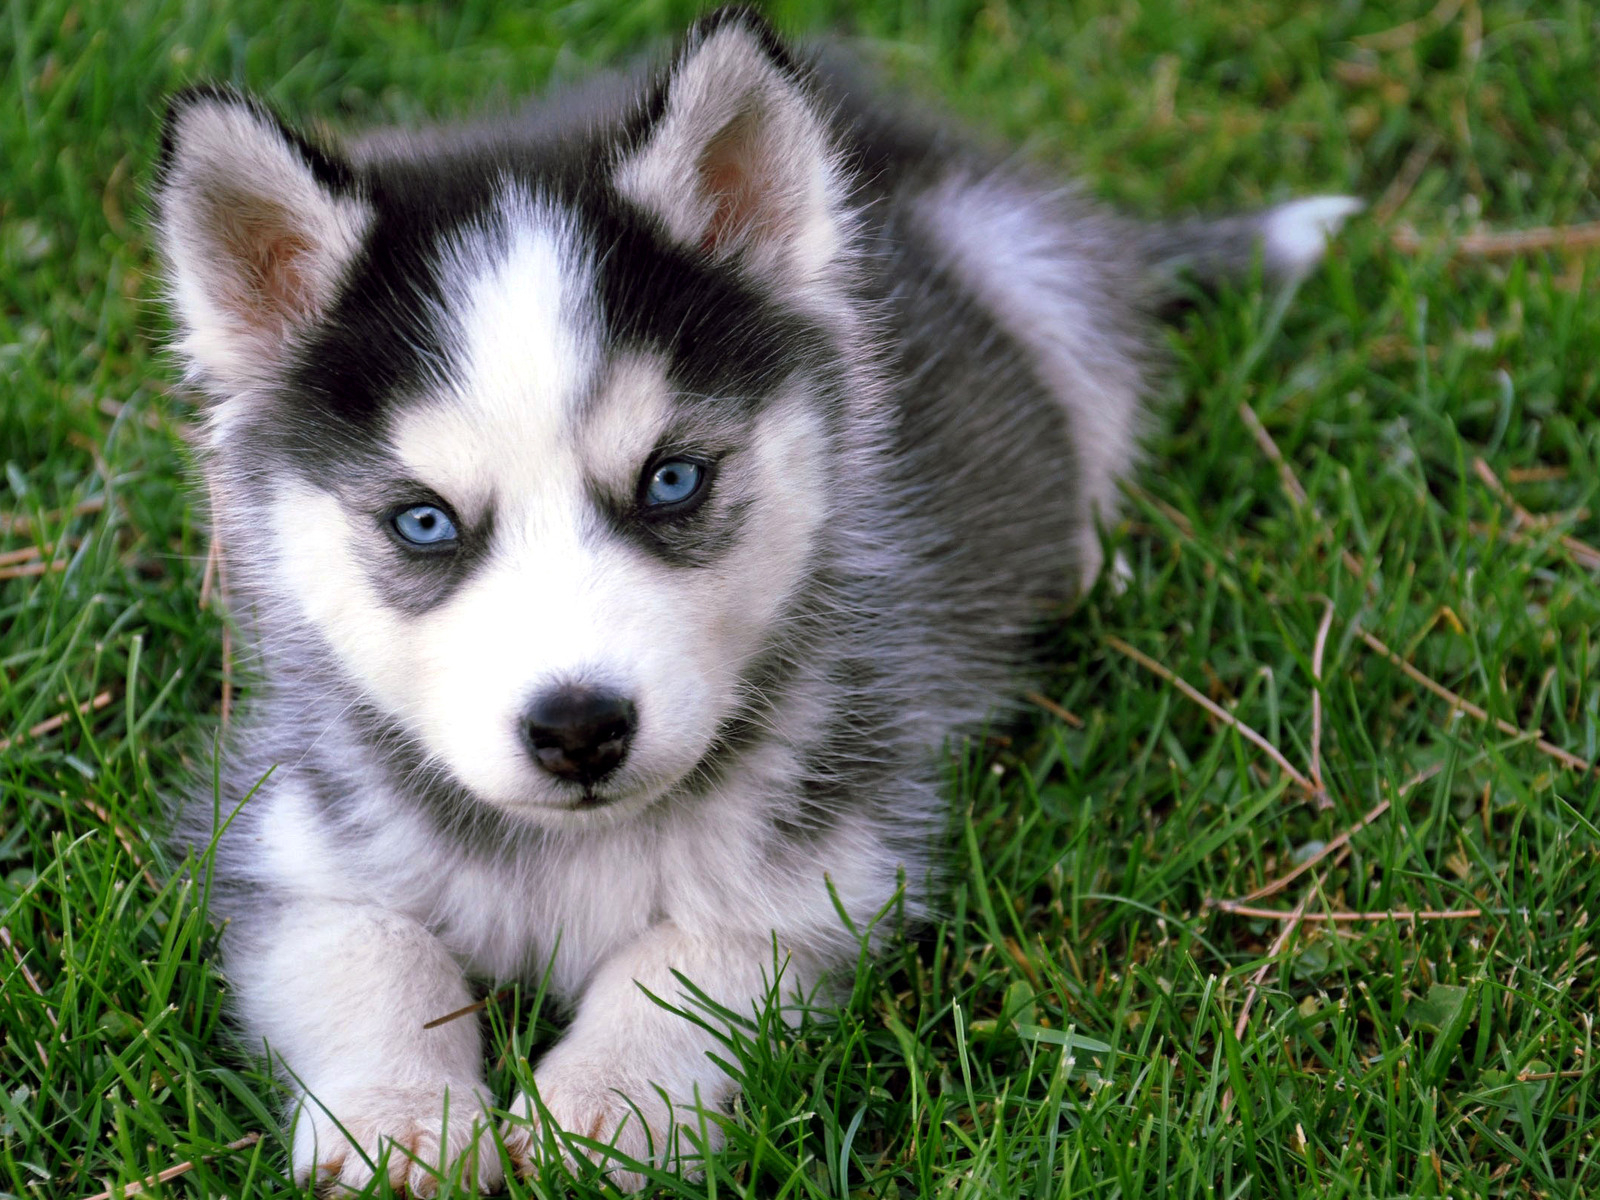


3. Setters (Irish) — score 0.90
  - Energy (5/5) — matches your activity level 5
  - Trainability (4/5) — fits your time for training 1
  - Good with kids: 5/5


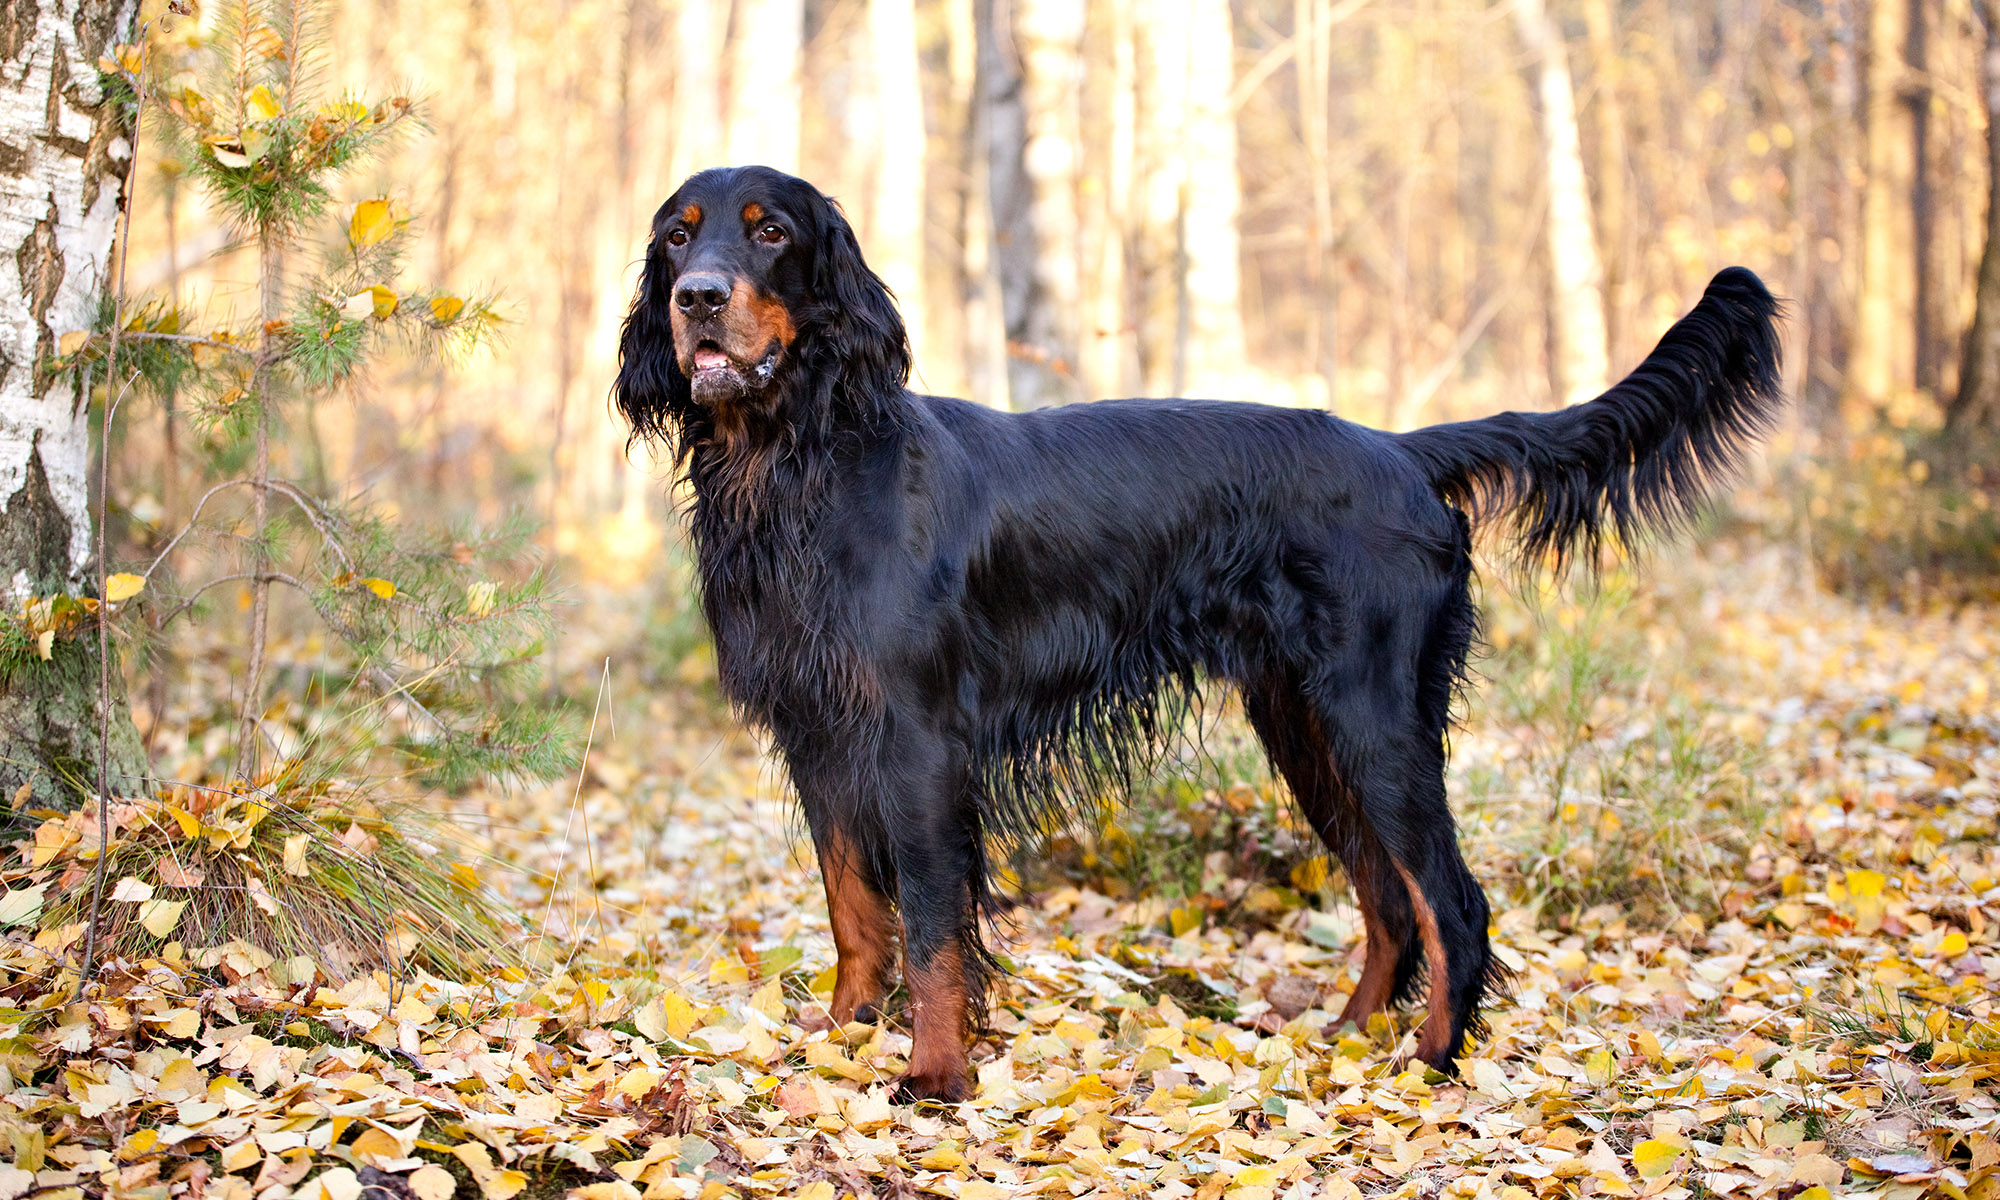

,breed,Affectionate With Family,good_with_kids,Good With Other Dogs,shedding,Coat Grooming Frequency,Drooling Level,Coat Type,Coat Length,Openness To Strangers,Playfulness Level,Watchdog/Protective Nature,Adaptability Level,trainability,energy,Barking Level,Mental Stimulation Needs,hypoallergenic,score
186,Finnish Spitz,5,5,4,3,2,2,Double,Medium,3,3,3,4,3,5,5,4,False,0.924211
15,Siberian Huskies,5,5,5,4,2,1,Double,Medium,5,5,1,4,3,5,5,4,False,0.924211
74,Setters (Irish),5,5,5,3,3,2,Silky,Medium,5,5,3,4,4,5,3,4,False,0.898947


In [25]:
from IPython.display import Image, display

# Interactive demo (notebook input)
def explain_match(row, prefs):
    reasons = []
    reasons.append(f"Energy ({int(row.get('energy',3))}/5) — matches your activity level {prefs.get('activity_level')}")
    reasons.append(f"Trainability ({int(row.get('trainability',3))}/5) — fits your time for training {prefs.get('time_for_training')}")
    if prefs.get('children'):
        reasons.append(f"Good with kids: {int(row.get('good_with_kids',3))}/5")
    if prefs.get('allergies'):
        reasons.append('Low shedding / hypoallergenic' if row.get('hypoallergenic') else 'Not hypoallergenic — may shed')
    return reasons

def notebook_chat_demo(df):
    print("Hi — I'm your Dog Matchmaker. I will ask a few quick questions.")
    activity = input('How active are you? (1=couch, 5=very active) [3]: ') or '3'
    try: activity = max(1, min(5, int(activity)))
    except: activity = 3
    home = input('Home type (apartment / house) [apartment]: ').strip().lower() or 'apartment'
    children = input('Any young children in home? (yes/no) [no]: ').strip().lower() in ['yes','y']
    allergies = input('Any dog allergies in home? (yes/no) [no]: ').strip().lower() in ['yes','y']
    time_train = input('Time/effort for training (1=little,5=lots) [3]: ') or '3'
    try: time_train = max(1, min(5, int(time_train)))
    except: time_train = 3
    size_pref = input('Preferred size (small/medium/large/no preference) [no preference]: ').strip().lower() or 'no preference'
    
    prefs = {
        'activity_level': activity,
        'home': home,
        'children': children,
        'allergies': allergies,
        'time_for_training': time_train,
        'size_pref': None if size_pref in ['no','no preference'] else size_pref
    }
    
    results = top_k_matches(df, prefs, k=3)
    
    print('\nTop 3 matches:')
    for i, (_, row) in enumerate(results.iterrows(), start=1):
        print(f"\n{i}. {row['breed']} — score {row['score']:.2f}")
        for r in explain_match(row, prefs):
            print(f"  - {r}")
        
        # image preview if mapping present
        img_path = None
        if MAPPING_JSON.exists():
            mp = json.load(open(MAPPING_JSON, encoding='utf8'))
            folder = mp.get(row['breed'], normalize_for_folder(row['breed']))
            p = IMAGES_DIR / folder
            if p.exists():
                imgs = sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png'))
                if imgs:
                    img_path = imgs[0]
        else:
            # try direct normalized folder
            p = IMAGES_DIR / normalize_for_folder(row['breed'])
            if p.exists():
                imgs = sorted(p.glob('*.jpg')) + sorted(p.glob('*.jpeg')) + sorted(p.glob('*.png'))
                if imgs:
                    img_path = imgs[0]
        
        # display image inline
        if img_path:
            display(Image(filename=img_path, width=300))
    
    return results

# To run interactive demo, uncomment and call:
notebook_chat_demo(breeds_df)


## 7 — Streamlit app (added to `app/app.py`)

Use this script to launch a lightweight chat-like UI. It uses the same matching code and mapping file for images.
